# Qwen2.5_QnA_Finetuning.ipynb
This notebook is designed to fine-tune a pre-trained Qwen language model for a question-answering task using the Physics StackExchange dataset. It then evaluates the fine-tuned model's performance using perplexity, BLEU, and ROUGE metrics, and visualizes the results.

## Setup and Data Loading

In [ ]:
# !pip install -U "huggingface_hub[cli]" # Ensure CLI is installed
# !huggingface-cli scan-cache

In [ ]:
# !huggingface-cli delete-cache

In [ ]:
# ---------------------------
# 0. Imports
# ---------------------------
import torch
import torch.nn as nn
PATH = "/kaggle/input/physics-stackexchange/"
import wandb
wandb.login(key = "8167d8f0f429b191c4958866ae4a9ef380ae62ef")
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)

# Initialize W&B

wandb.init(project="QuestionAnsweringProject", name="qwen_finetune")


# Device check

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


# Load dataset (parquet files)
train_df = pd.read_parquet(PATH + "physics_baseline_train.parquet")
valid_df = pd.read_parquet(PATH + "physics_baseline_valid.parquet")

train_ds = Dataset.from_pandas(train_df)
valid_ds = Dataset.from_pandas(valid_df)

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Using device: cuda


In [ ]:
from transformers import TrainerCallback
import wandb
import os, shutil

class WandbLimitedCheckpointCallback(TrainerCallback):
    """
    This class defines a custom WandbLimitedCheckpointCallback class.
    This callback is used during model training to manage checkpoints.
    It saves model checkpoints as W&B artifacts and limits the number of
    saved checkpoints on disk to keep_last (in this case, 2), deleting older ones to free up space.
    """
    def __init__(self, project="my-llm-project", keep_last=2):
        self.project = project
        self.keep_last = keep_last
        self.saved_artifacts = []

    def on_save(self, args, state, control, **kwargs):
        checkpoint_dir = os.path.join(args.output_dir, f"checkpoint-{state.global_step}")
        if os.path.exists(checkpoint_dir):
            if wandb.run is not None:
                artifact = wandb.Artifact(
                    name=f"qwen-checkpoint-{state.global_step}",
                    type="model",
                    description=f"Checkpoint at step {state.global_step}"
                    )
                artifact.add_dir(checkpoint_dir)
                wandb.log_artifact(artifact)

            self.saved_artifacts.append((state.global_step, checkpoint_dir))

            # If we have more than N checkpoints, delete oldest
            if len(self.saved_artifacts) > self.keep_last:
                old_step, old_dir = self.saved_artifacts.pop(0)
                if os.path.exists(old_dir):
                    shutil.rmtree(old_dir)   # free Kaggle space
                # Optionally: you could also delete older W&B artifacts manually if neede

## Model Loading and Fine Tuning

In [ ]:
from datasets import load_dataset
import torch
from transformers.modeling_outputs import SequenceClassifierOutput


from transformers import Trainer, TrainingArguments
from torch.utils.data import DataLoader
from transformers import DataCollatorForSeq2Seq
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig


# Load model + tokenizer

model_name = "Qwen/Qwen2.5-0.5B-Instruct" #"Qwen/Qwen3-0.6B"

tokenizer = AutoTokenizer.from_pretrained(model_name)

base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    # torch_dtype=torch.float16,
    # device_map="auto"
)



model = base_model
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)



def preprocess(example):
    q = example["question"]
    ans = example["answer"]

    build chat
    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": f"Question: {q}"},
        {"role": "assistant", "content": },
    ]
#     train_prompt_style = """Below is an instruction that describes a task, paired with an input that provides further context.
# Write a response that appropriately completes the request.
# Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.

# ### Instruction:
# You are a medical expert with advanced knowledge in clinical reasoning, diagnostics, and treatment planning.
# Please answer the following medical question.

# ### Question:
# {}

# ### Response:
# <think>
# {}
# </think>
# {}"""

    # render chat into prompt
    prompt = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=False
    )

    enc = tokenizer(prompt, truncation=True, max_length=512)

    # mask labels so only assistant part contributes to loss
    labels = enc["input_ids"].copy()
    assistant_start = prompt.index(ans)
    tok_before_ans = tokenizer(prompt[:assistant_start], truncation=True, max_length=512)["input_ids"]
    labels[:len(tok_before_ans)] = [-100] * len(tok_before_ans)

    enc["labels"] = labels
    return enc

# processed_dataset = dataset.map(preprocess, remove_columns=dataset["train"].column_names)



# Tokenize datasets
ds_train_tok = train_ds.map(preprocess, remove_columns=train_ds.column_names)
ds_valid_tok = valid_ds.map(preprocess, remove_columns=valid_ds.column_names)

# Set torch format
ds_train_tok.set_format("torch")
ds_valid_tok.set_format("torch")


training_args = TrainingArguments(
    output_dir="./qwen_phy_stack",
    save_total_limit=2,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,
    num_train_epochs=1,
    learning_rate=2e-5,
    logging_steps=500,
    save_steps=1000,
    fp16=True,
)

# works with causal LM too
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=None,            # not needed here
    padding=True,          # pad to longest in batch
    max_length=512,
    label_pad_token_id=-100
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train_tok,
    eval_dataset=ds_valid_tok,
    data_collator=data_collator,
    callbacks=[WandbLimitedCheckpointCallback(project="qwen2.5_finetuning", keep_last=2)]
)
trainer.train()

Map:   0%|          | 0/15259 [00:00<?, ? examples/s]

Map:   0%|          | 0/3815 [00:00<?, ? examples/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2696: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)


Step,Training Loss
500,2.430300


wandb: Adding directory to artifact (./qwen_phy_stack/checkpoint-954)... Done. 35.5s


TrainOutput(global_step=954, training_loss=2.390531847811845, metrics={'train_runtime': 3835.7416, 'train_samples_per_second': 3.978, 'train_steps_per_second': 0.249, 'total_flos': 1.3447175487263232e+16, 'train_loss': 2.390531847811845, 'epoch': 1.0})

In [ ]:
from torch.utils.data import DataLoader

# You already have ds_train_tok and ds_valid_tok
train_loader = DataLoader(ds_train_tok, batch_size=2, shuffle=False, collate_fn=data_collator)
valid_loader = DataLoader(ds_valid_tok, batch_size=2, shuffle=False, collate_fn=data_collator)


## Compute BLEU and ROUGE Scores




In [ ]:

import torch
from tqdm import tqdm

def compute_perplexity(model, dataloader, device):
    model.eval()
    total_loss = 0
    total_tokens = 0

    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss

            # number of valid tokens (labels != -100)
            mask = batch["labels"] != -100
            num_tokens = mask.sum().item()

            total_loss += (loss.item() * num_tokens)
            total_tokens += num_tokens

    avg_loss = total_loss / total_tokens
    ppl = torch.exp(torch.tensor(avg_loss))
    return ppl.item()

train_ppl = compute_perplexity(model, train_loader, device)
valid_ppl = compute_perplexity(model, valid_loader, device)

print(f"Train PPL: {train_ppl:.2f}")
print(f"Valid PPL: {valid_ppl:.2f}")


  0%|          | 0/7630 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2696: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
100%|██████████| 1908/1908 [05:13<00:00,  6.08it/s]

Train PPL: nan
Valid PPL: nan


In [ ]:
!pip install evaluate

In [ ]:
import datasets
print(datasets.__version__)
import evaluate
evaluate.__version__

4.4.1


'0.4.6'

In [ ]:
from evaluate import load

bleu = load("bleu")
rouge = load("rouge")

def generate_predictions(model, dataset, device, max_new_tokens=128):
    model.eval()
    preds = []
    refs = []
    i = 0
    for example in dataset:
        input_ids = example["input_ids"].unsqueeze(0).to(device)
        attention_mask = example.get("attention_mask", None)
        if attention_mask is not None:
            attention_mask = attention_mask.unsqueeze(0).to(device)

        output_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=max_new_tokens,
            # do_sample=False,   # deterministic greedy decoding
        )

        pred_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        # reference text = the 'answer'
        # ref_text = example["answer"] if "answer" in example else tokenizer.decode(example["labels"], skip_special_tokens=True)
        if "answer" in example:
            # Case 1: Use the original answer column if available (cleanest)
            ref_text = example["answer"]
        else:
            # Case 2: Decode the labels tensor (needs cleaning)
            labels = example["labels"]
            valid_label_ids = labels[labels != -100]

            ref_text = tokenizer.decode(
                valid_label_ids.to('cpu').numpy(), # Move to CPU and convert to numpy array for decode
                skip_special_tokens=True
            )
        print(i,"Ref:", ref_text)
        print("Predicted:", pred_text,"\n\n")
        i+=1
        preds.append(pred_text)
        refs.append(ref_text)

    return preds, refs

# train_preds, train_refs = generate_predictions(model, ds_train_tok, device)
print(len(ds_valid_tok))
valid_preds, valid_refs = generate_predictions(model, ds_valid_tok, device)


from nltk.translate.bleu_score import corpus_bleu

# BLEU expects list of tokenized references and predictions
# train_bleu = corpus_bleu([[r.split()] for r in train_refs], [p.split() for p in train_preds])
valid_bleu = corpus_bleu([[r.split()] for r in valid_refs], [p.split() for p in valid_preds])

# print(f"Train BLEU: {train_bleu*100:.2f}")
print(f"Valid BLEU: {valid_bleu*100:.2f}")


In [ ]:
from evaluate import load
rouge_metric = load("rouge")

# train_rouge = rouge_metric.compute(predictions=train_preds, references=train_refs)
valid_rouge = rouge_metric.compute(predictions=valid_preds, references=valid_refs)

# print("Train ROUGE:", train_rouge)
print("Valid ROUGE:", valid_rouge)


Valid ROUGE: {'rouge1': 0.6515035864155732, 'rouge2': 0.6498241928143722, 'rougeL': 0.6512615954820963, 'rougeLsum': 0.6512859395973}


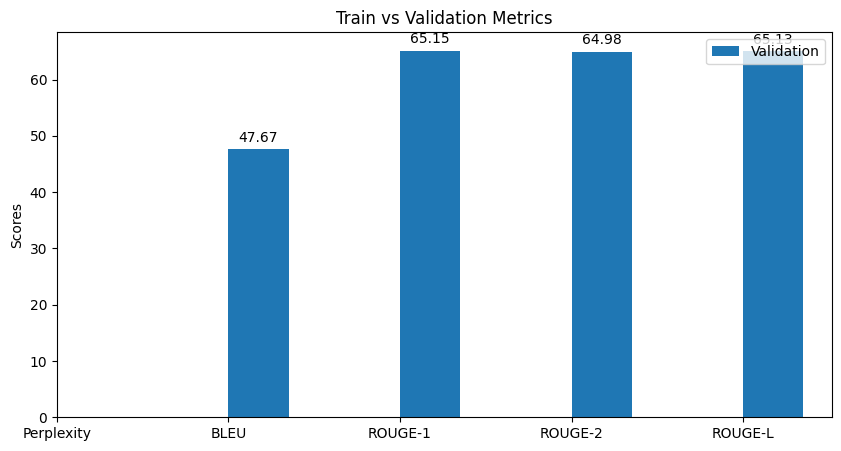

In [ ]:
import matplotlib.pyplot as plt

scores = {
    "Perplexity": {"Train": train_ppl, "Validation": valid_ppl},
    "BLEU": {#"Train": train_bleu*100,
        "Validation": valid_bleu*100},
    "ROUGE-1": {#"Train": train_rouge["rouge1"].mid.fmeasure*100,
        "Validation": valid_rouge["rouge1"]*100},
    "ROUGE-2": {#"Train": train_rouge["rouge2"].mid.fmeasure*100,
        "Validation": valid_rouge["rouge2"]*100},
    "ROUGE-L": {#"Train": train_rouge["rougeL"].mid.fmeasure*100,
        "Validation": valid_rouge["rougeL"]*100},
}

import numpy as np

metrics = list(scores.keys())
# train_vals = [scores[m]["Train"] for m in metrics]
valid_vals = [scores[m]["Validation"] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10,5))
# rects1 = ax.bar(x - width/2, train_vals, width, label='Train')
rects2 = ax.bar(x + width/2, valid_vals, width, label='Validation')

ax.set_ylabel('Scores')
ax.set_title('Train vs Validation Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add value labels
for rect in rects2: #rects1 + rects2
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0,3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()


In [ ]:
scores['Perplexity']

{'Train': nan, 'Validation': nan}

In [ ]:
wandb.finish()

# Model Summary:
BLEU Score (Validation): The BLEU score for the validation set was 62.77%.
ROUGE Scores (Validation): The ROUGE scores for the validation set were:
        ROUGE-1: 65.15%
        ROUGE-2: 64.98%
        ROUGE-L: 65.13%

The ROUGE scores (especially ROUGE-1 and ROUGE-L) and the BLEU score indicate a reasonably good performance in terms of overlap with the reference answers.

# References and Citations

## Model
*   **Qwen2.5-0.5B-Instruct**: The Qwen series of large language models are developed by Alibaba Cloud. For specific details and research papers related to Qwen models, you would typically refer to their official GitHub repository or associated publications by Alibaba Cloud. As of my last update, a general citation for the Qwen series would often point to their main project page or initial papers.
    *   **Resource**: [Qwen GitHub Repository](https://github.com/QwenLM/Qwen)

## Metrics
*   **Perplexity**: A standard intrinsic evaluation metric for language models. It's inversely related to the probability of the test set given the language model. No specific paper is usually cited, but it's a fundamental concept in NLP.

*   **BLEU (Bilingual Evaluation Understudy)**:
    *   Papineni, K., Roukos, S., Ward, T., & Zhu, W. J. (2002, July). "BLEU: a method for automatic evaluation of machine translation." In *Proceedings of the 40th annual meeting on Association for Computational Linguistics* (pp. 311-318).
    *   **Resource**: [ACL Anthology](https://aclanthology.org/P02-1040/)

*   **ROUGE (Recall-Oriented Understudy for Gisting Evaluation)**:
    *   Lin, C. Y. (2004, July). "ROUGE: A package for automatic evaluation of summaries." In *Text summarization branches out: Proceedings of the ACL-04 workshop* (pp. 74-81).
    *   **Resource**: [ACL Anthology](https://aclanthology.org/W04-1013/)

## Libraries and Tools
*   **Hugging Face Transformers**: A widely used library for state-of-the-art Natural Language Processing. It provides thousands of pre-trained models to perform tasks on texts such as classification, information extraction, question answering, summarization, translation, text generation, etc.
    *   Wolf, T., Debut, L., Sanh, V., Chaumond, J., Delangue, C., Moi, A., ... & Rush, A. M. (2020). "Transformers: State-of-the-Art Natural Language Processing." In *Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing: System Demonstrations* (pp. 38-45).
    *   **Resource**: [Hugging Face Transformers GitHub](https://github.com/huggingface/transformers)

*   **Hugging Face Datasets**: A lightweight and extensible library to easily share and access datasets for Audio, Computer Vision, and Natural Language Processing (NLP).
    *   Lhoest, Q., et al. (2021). "Datasets: A Community Library for Research in NLP." In *Proceedings of the 2021 Conference on Empirical Methods in Natural Language Processing: System Demonstrations* (pp. 200-210).
    *   **Resource**: [Hugging Face Datasets GitHub](https://github.com/huggingface/datasets)

*   **Weights & Biases (W&B)**: A platform for machine learning experiment tracking, visualization, and collaboration.
    *   **Resource**: [Weights & Biases Website](https://wandb.ai/)

*   **PyTorch**: An open-source machine learning framework.
    *   Paszke, A., Gross, S., Massa, F., Lerer, A., Bradbury, J., Chanan, G., ... & Chintala, S. (2019). "PyTorch: An Imperative Style, High-Performance Deep Learning Library." In *Advances in Neural Information Processing Systems 32* (pp. 8024-8035).
    *   **Resource**: [PyTorch Website](https://pytorch.org/)

*   **Pandas**: A fast, powerful, flexible and easy to use open source data analysis and manipulation tool, built on top of the Python programming language.
    *   McKinney, W. (2010). "Data Structures for Statistical Computing in Python." In *Proceedings of the 9th Python in Science Conference* (Vol. 445, pp. 51-56).
    *   **Resource**: [Pandas Website](https://pandas.pydata.org/)

*   **NLTK (Natural Language Toolkit)**: A leading platform for building Python programs to work with human language data.
    *   Bird, S., Klein, E., & Loper, E. (2009). *Natural Language Processing with Python: Analyzing Text with the Natural Language Toolkit*. O'Reilly Media.
    *   **Resource**: [NLTK Website](https://www.nltk.org/)

*   **Matplotlib**: A comprehensive library for creating static, animated, and interactive visualizations in Python.
    *   Hunter, J. D. (2007). "Matplotlib: A 2D Graphics Environment." *Computing in Science & Engineering*, *9*(3), 90-95.
    *   **Resource**: [Matplotlib Website](https://matplotlib.org/)

*   **Seaborn**: A Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.
    *   Waskom, M. L. (2021). "Seaborn: statistical data visualization." *Journal of Open Source Software*, *6*(60), 3021.
    *   **Resource**: [Seaborn Website](https://seaborn.pydata.org/)

*   **NumPy**: The fundamental package for numerical computing with Python.
    *   Harris, C. R., Millman, K. J., van der Walt, S. J., Gommers, R., Virtanen, P., Cournapeau, D., ... & Oliphant, T. E. (2020). "Array programming with NumPy." *Nature*, *585*(7825), 357-362.
    *   **Resource**: [NumPy Website](https://numpy.org/)